# Libraries

In [52]:
import os
import kagglehub
import sys
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms,models
from tqdm.notebook import tqdm
!pip install torchcam
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import cv2
import matplotlib.cm as cm
from torchsummary import summary

torch.backends.cudnn.deterministic = True

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

# Device checking

In [36]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


# Data set loading

In [3]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


getting the folders path

In [4]:
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")
print("Will read data from", train_dir)
print("Will read data from", val_dir)
print("Will read data from", test_dir)

Will read data from /kaggle/input/chest-xray-pneumonia/chest_xray/train
Will read data from /kaggle/input/chest-xray-pneumonia/chest_xray/val
Will read data from /kaggle/input/chest-xray-pneumonia/chest_xray/test


# Visualization

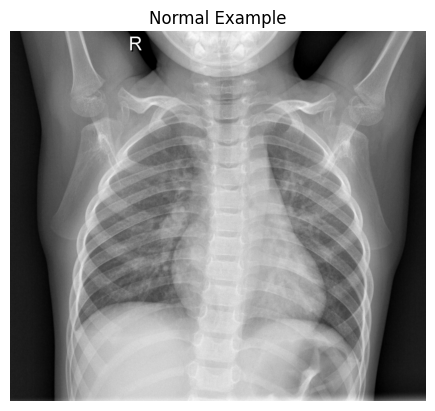

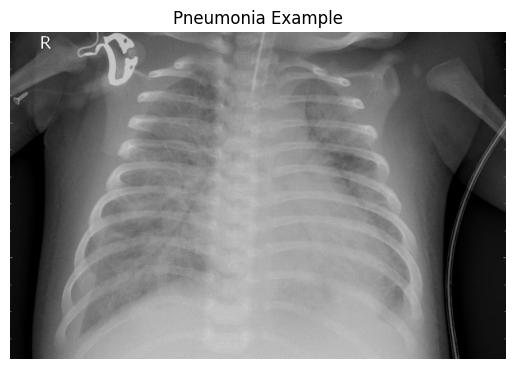

In [5]:
img_path='/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
img = Image.open(img_path)
# Display the image
plt.imshow(img, cmap='gray')
plt.title("Normal Example")
plt.axis('off')
plt.show()
img_path='/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'
img = Image.open(img_path)
# Display the image
plt.imshow(img, cmap='gray')
plt.title("Pneumonia Example")
plt.axis('off')
plt.show()

# Basic Preprocessing

In [6]:
transform = transforms.Compose(
    [
        
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
    ]
)

# Making Datasets

In [7]:
traindataset = datasets.ImageFolder(train_dir, transform=transform)
valdataset = datasets.ImageFolder(val_dir, transform=transform)
testdataset = datasets.ImageFolder(test_dir, transform=transform)

# Finding number of classes

In [8]:
classes=traindataset.classes
print("Classes :",classes)
print(f"That's {len(traindataset.classes)} classes")
print()
print("Tensor shape for one image:")
print(traindataset[0][0].shape)

Classes : ['NORMAL', 'PNEUMONIA']
That's 2 classes

Tensor shape for one image:
torch.Size([3, 224, 224])


# Making Loaders

In [9]:
batch_size = 32
train_dataset_loader = DataLoader(traindataset, batch_size=batch_size)
val_dataset_loader = DataLoader(valdataset, batch_size=batch_size)
test_dataset_loader = DataLoader(testdataset, batch_size=batch_size)

# Calculating the mean and standard deviation of datasets

In [10]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [11]:
#for train
mean, std = get_mean_std(train_dataset_loader)


print(f"Mean: {mean}")
print(f"Standard deviation: {std}")
#for val
mean1, std1 = get_mean_std(val_dataset_loader)


print(f"Mean: {mean1}")
print(f"Standard deviation: {std1}")

#for test
mean2, std2 = get_mean_std(test_dataset_loader)


print(f"Mean: {mean2}")
print(f"Standard deviation: {std2}")

Computing mean and std:   0%|          | 0/163 [00:00<?, ?it/s]

Mean: tensor([0.4823, 0.4823, 0.4823])
Standard deviation: tensor([0.2361, 0.2361, 0.2361])


Computing mean and std:   0%|          | 0/1 [00:00<?, ?it/s]

Mean: tensor([0.4900, 0.4900, 0.4900])
Standard deviation: tensor([0.2550, 0.2550, 0.2550])


Computing mean and std:   0%|          | 0/20 [00:00<?, ?it/s]

Mean: tensor([0.4743, 0.4743, 0.4743])
Standard deviation: tensor([0.2356, 0.2356, 0.2356])


# Normalization  according to the mean and std

In [12]:
transform_norm = transforms.Compose(
    [
        transforms.RandomRotation(10),               # Rotate ±10 degrees
        transforms.RandomHorizontalFlip(0.5),        # Flip 50% of images
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translations
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]
)
transform_norm1 = transforms.Compose(
    [
        
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean1, std=std1),
    ]
)

transform_norm2 = transforms.Compose(
    [
        
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean2, std=std2),
    ]
)

# Normalized Datasets

In [13]:
train_norm_dataset =datasets.ImageFolder(train_dir, transform=transform_norm )
train_loader = DataLoader(train_norm_dataset, batch_size=batch_size,shuffle=True)
val_norm_dataset =datasets.ImageFolder(val_dir, transform=transform_norm1)
val_loader = DataLoader(val_norm_dataset, batch_size=batch_size,shuffle=False)
test_norm_dataset =datasets.ImageFolder(test_dir, transform=transform_norm2)
test_loader = DataLoader(test_norm_dataset, batch_size=batch_size,shuffle=False)

# Calculating class distributions

In [14]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.class_to_idx  # Remove the extra .dataset
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [15]:
train_class_distributions = class_counts(train_norm_dataset)
val_class_distributions = class_counts(val_norm_dataset)
test_class_distributions = class_counts(test_norm_dataset)

print('Train class Distribution:',train_class_distributions)
print('Val class Distribution:',val_class_distributions)
print('Test class Distribution:',test_class_distributions)

  0%|          | 0/5216 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

Train class Distribution: NORMAL       1341
PNEUMONIA    3875
dtype: int64
Val class Distribution: NORMAL       8
PNEUMONIA    8
dtype: int64
Test class Distribution: NORMAL       234
PNEUMONIA    390
dtype: int64


# Bar charts of class distirbutions

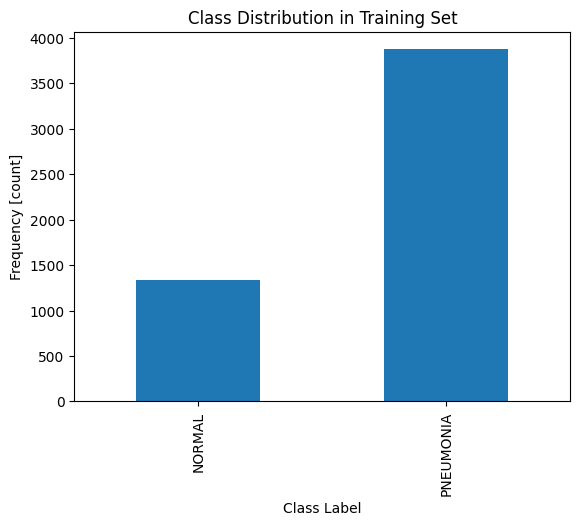

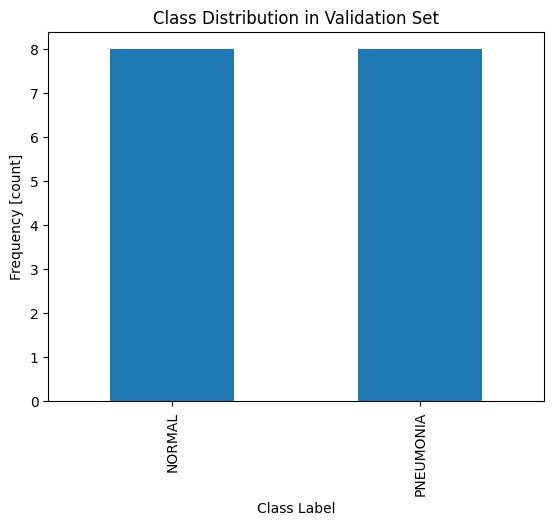

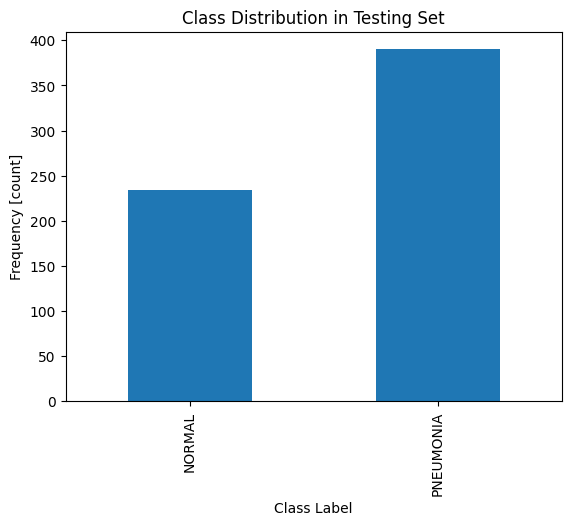

In [16]:
# Create a bar plot from train_class_distribution
train_class_distributions.plot(kind='bar')
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Training Set");
plt.show() 
# Create a bar plot from val_class_distribution
val_class_distributions.plot(kind='bar')
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Validation Set");
plt.show() 
# Create a bar plot from test_class_distribution
test_class_distributions.plot(kind='bar')
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Testing Set");
plt.show() 

# Resnet 50 model

In [17]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

print(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 228MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Last Layer

In [18]:
num_classes = 2  # Normal and Pneumonia
model.fc = nn.Linear(model.fc.in_features, num_classes)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Moving model to cuda

In [19]:
model = model.to(device)

# Model Arictecture

In [65]:
summary(model, input_size=(3, 224, 224))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# Loss Function ,optimizers and  sheduler

In [20]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# Train the model on 10 epochs

In [21]:
def score(model, data_loader, loss_fn, device="cpu"):
    total_loss = 0
    total_correct = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    n_observations = data_loader.batch_size * len(data_loader)
    average_loss = total_loss / n_observations
    accuracy = total_correct / n_observations
    return average_loss, accuracy

def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):
    training_loss = 0.0
    model.train()
    # Iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()
        training_loss += loss.data.item() * inputs.size(0)

    return training_loss / len(data_loader.dataset)
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device="cpu",
    use_train_accuracy=True,
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        # Train one epoch
        training_loss = train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Evaluate training results
        if use_train_accuracy:
            train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        else:
            train_loss = training_loss
            train_accuracy = 0
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Test on validation set
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"    Training loss: {train_loss:.2f}")
        if use_train_accuracy:
            print(f"    Training accuracy: {train_accuracy:.2f}")
        print(f"    Validation loss: {validation_loss:.2f}")
        print(f"    Validation accuracy: {validation_accuracy:.2f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [22]:
epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = train(
    model, optimizer, criterion, train_loader, val_loader, epochs, device=device
)

Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 0.60
    Training accuracy: 0.81
    Validation loss: 0.70
    Validation accuracy: 0.28


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 0.14
    Training accuracy: 0.94
    Validation loss: 0.27
    Validation accuracy: 0.38


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.29
    Training accuracy: 0.89
    Validation loss: 0.11
    Validation accuracy: 0.47


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.06
    Training accuracy: 0.98
    Validation loss: 0.10
    Validation accuracy: 0.47


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.19
    Training accuracy: 0.92
    Validation loss: 0.25
    Validation accuracy: 0.38


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.05
    Training accuracy: 0.98
    Validation loss: 0.23
    Validation accuracy: 0.38


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 7
    Training loss: 0.08
    Training accuracy: 0.97
    Validation loss: 0.19
    Validation accuracy: 0.41


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 8
    Training loss: 0.09
    Training accuracy: 0.98
    Validation loss: 0.30
    Validation accuracy: 0.34


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 9
    Training loss: 0.07
    Training accuracy: 0.98
    Validation loss: 0.47
    Validation accuracy: 0.31


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10
    Training loss: 0.06
    Training accuracy: 0.98
    Validation loss: 0.20
    Validation accuracy: 0.44


# Training and validation curves.

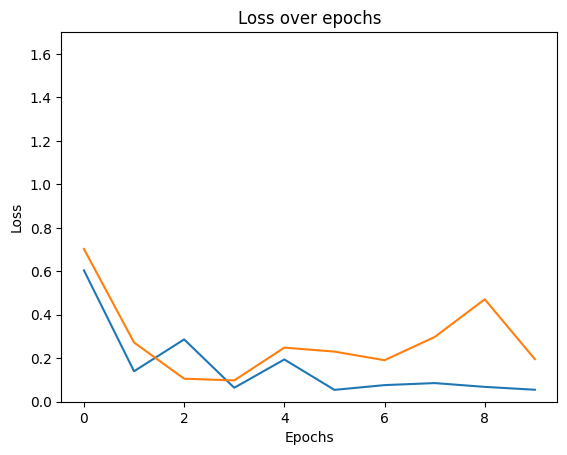

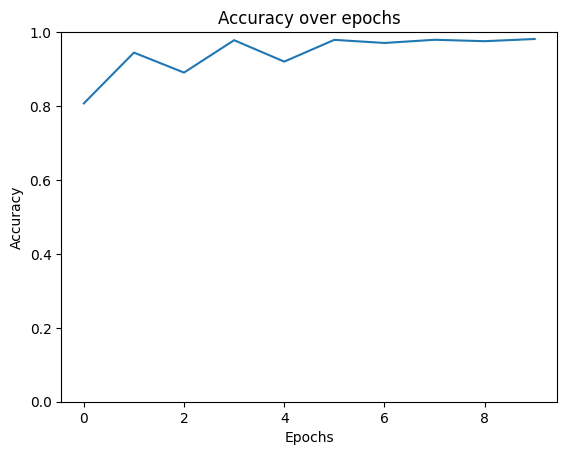

In [27]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.ylim([0, 1.7])
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(epochs, label="Epochs")
plt.ylim([0, 1])
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


# Prediction

In [28]:
def predict(model, data_loader, device="cpu"):
    all_probs = torch.tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)
            probs = torch.nn.functional.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs
probabilities_val = predict(model, test_loader, device)
predictions_val = torch.argmax(probabilities_val, dim=1)
print(predictions_val)

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Confusion Matrix

Get Labels:   0%|          | 0/20 [00:00<?, ?it/s]

<Figure size 1000x800 with 0 Axes>

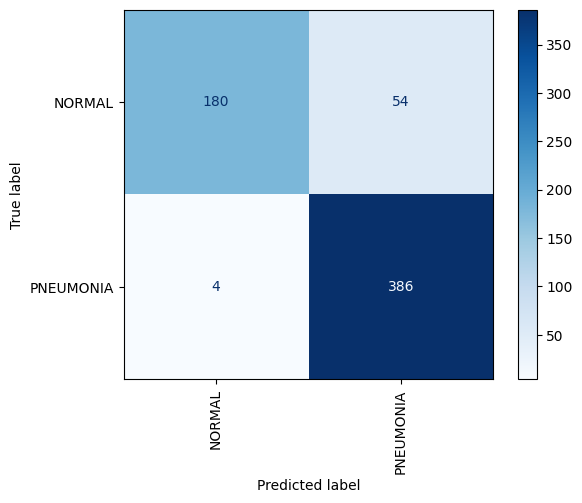

In [29]:
targets_val = torch.cat([labels for _, labels in tqdm(test_loader, desc="Get Labels")])

cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

# Accuracy, precision, recall, F1-score,

In [30]:
# Accuracy
accuracy = accuracy_score(targets_val.cpu(), predictions_val.cpu())

# Precision
precision = precision_score(targets_val.cpu(), predictions_val.cpu(), average='weighted')

# Recall
recall = recall_score(targets_val.cpu(), predictions_val.cpu(), average='weighted')

# F1 Score
f1 = f1_score(targets_val.cpu(), predictions_val.cpu(), average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9071
Precision: 0.9151
Recall:    0.9071
F1 Score:  0.9043


# MobileNet Model

In [38]:
model1 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)


setting last layer for 2 labels only

In [39]:
model1.classifier[1] = nn.Linear(model1.classifier[1].in_features, 2) 
print(model1)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# Model Arcitecture

In [64]:


summary(model1, input_size=(3, 224, 224))  # Example for RGB image


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

load the model on the gpu

In [40]:
model1 = model1.to(device)

# loss function and optimizer and shedular for mobilenet

In [41]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# Training the model

In [42]:
epochs = 10
train_losses1, val_losses1, train_accuracies1, val_accuracies1 = train(
    model1, optimizer, criterion, train_loader, val_loader, epochs, device=device
)

Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 0.07
    Training accuracy: 0.98
    Validation loss: 0.16
    Validation accuracy: 0.41


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.10
    Training accuracy: 0.96
    Validation loss: 0.12
    Validation accuracy: 0.44


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.06
    Training accuracy: 0.98
    Validation loss: 0.25
    Validation accuracy: 0.41


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.03
    Training accuracy: 0.99
    Validation loss: 0.11
    Validation accuracy: 0.47


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.05
    Training accuracy: 0.98
    Validation loss: 0.46
    Validation accuracy: 0.31


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 7
    Training loss: 0.04
    Training accuracy: 0.98
    Validation loss: 0.12
    Validation accuracy: 0.44


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 8
    Training loss: 0.07
    Training accuracy: 0.98
    Validation loss: 0.03
    Validation accuracy: 0.50


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 9
    Training loss: 0.03
    Training accuracy: 0.99
    Validation loss: 0.12
    Validation accuracy: 0.41


Training:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/163 [00:00<?, ?it/s]

Scoring:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10
    Training loss: 0.03
    Training accuracy: 0.99
    Validation loss: 0.12
    Validation accuracy: 0.44


# Training and validation curves

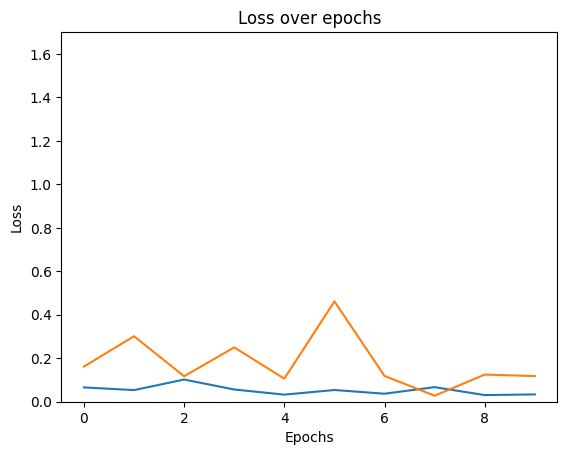

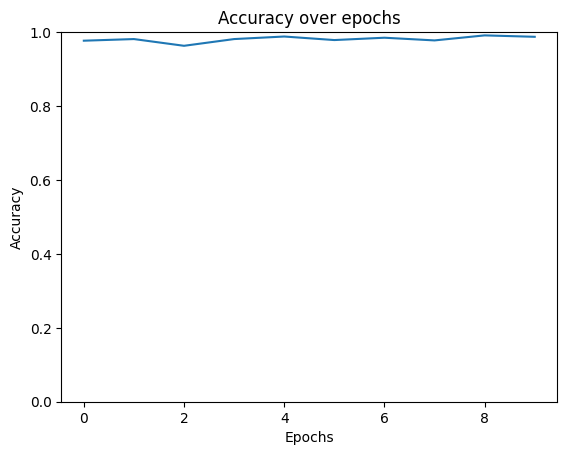

In [43]:
plt.plot(train_losses1, label="Training Loss")
plt.plot(val_losses1, label="Validation Loss")
plt.ylim([0, 1.7])
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
plt.plot(train_accuracies1, label="Training Accuracy")
plt.plot(epochs, label="Epochs")
plt.ylim([0, 1])
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


# Predictions

In [44]:
probabilities_val1 = predict(model1, test_loader, device)
predictions_val1 = torch.argmax(probabilities_val1, dim=1)
print(predictions_val1)

Predicting:   0%|          | 0/20 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Confusion Matrix

<Figure size 1000x800 with 0 Axes>

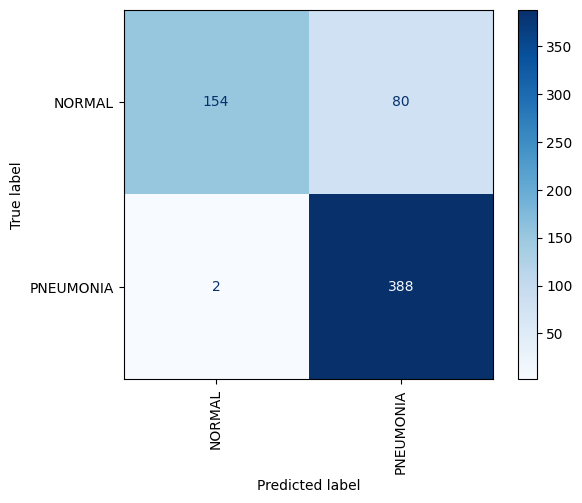

In [46]:

cm1 = confusion_matrix(targets_val.cpu(), predictions_val1.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

# Accuracy Precision  recall and f1 score

In [47]:
# Accuracy
accuracy1 = accuracy_score(targets_val.cpu(), predictions_val1.cpu())

# Precision
precision1 = precision_score(targets_val.cpu(), predictions_val1.cpu(), average='weighted')

# Recall
recall1 = recall_score(targets_val.cpu(), predictions_val1.cpu(), average='weighted')

# F1 Score
f11 = f1_score(targets_val.cpu(), predictions_val1.cpu(), average='weighted')

print(f"Accuracy:  {accuracy1:.4f}")
print(f"Precision: {precision1:.4f}")
print(f"Recall:    {recall1:.4f}")
print(f"F1 Score:  {f11:.4f}")

Accuracy:  0.8686
Precision: 0.8884
Recall:    0.8686
F1 Score:  0.8614


# Comparisons between restnet50 and mobilenet

In [48]:
comparison_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "ResNet50": [accuracy, precision, recall, f1],
    "MobileNet": [accuracy1, precision1, recall1, f11]
}

df_comparison = pd.DataFrame(comparison_data)
df_comparison

,Metric,ResNet50,MobileNet
0,Accuracy,0.907051,0.868590
1,Precision,0.915143,0.888355
2,Recall,0.907051,0.868590
3,F1 Score,0.904292,0.861422


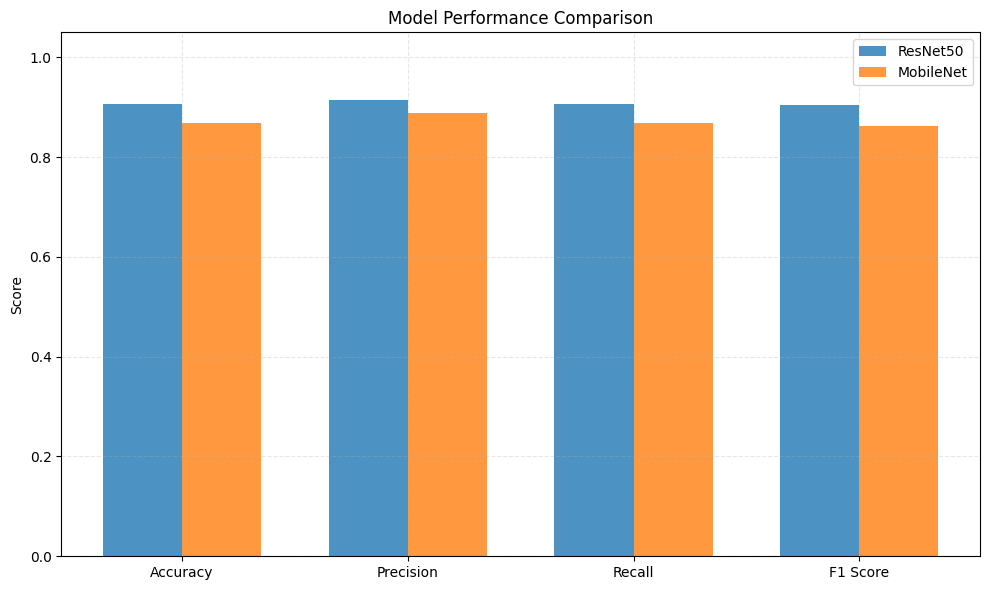

In [49]:
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
resnet_scores = [accuracy, precision, recall, f1]
mobilenet_scores = [accuracy1, precision1, recall1, f11]

x = range(len(metrics))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, resnet_scores, width=bar_width, label="ResNet50", alpha=0.8)
plt.bar([i + bar_width for i in x], mobilenet_scores, width=bar_width, label="MobileNet", alpha=0.8)

plt.xticks([i + bar_width / 2 for i in x], metrics)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


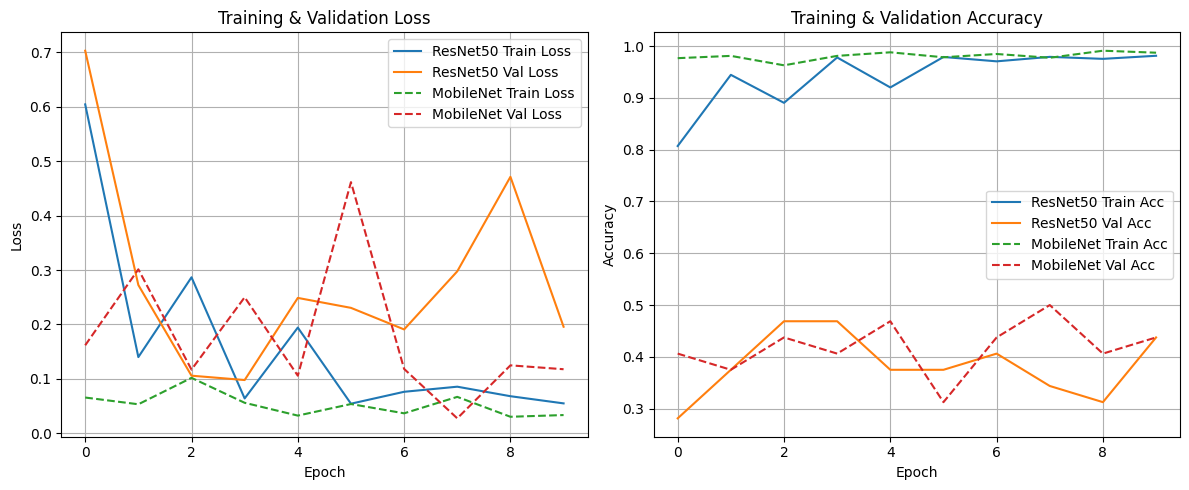

In [50]:
# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="ResNet50 Train Loss")
plt.plot(val_losses, label="ResNet50 Val Loss")
plt.plot(train_losses1, label="MobileNet Train Loss", linestyle='--')
plt.plot(val_losses1, label="MobileNet Val Loss", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="ResNet50 Train Acc")
plt.plot(val_accuracies, label="ResNet50 Val Acc")
plt.plot(train_accuracies1, label="MobileNet Train Acc", linestyle='--')
plt.plot(val_accuracies1, label="MobileNet Val Acc", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Visual examples (Grad-CAM )

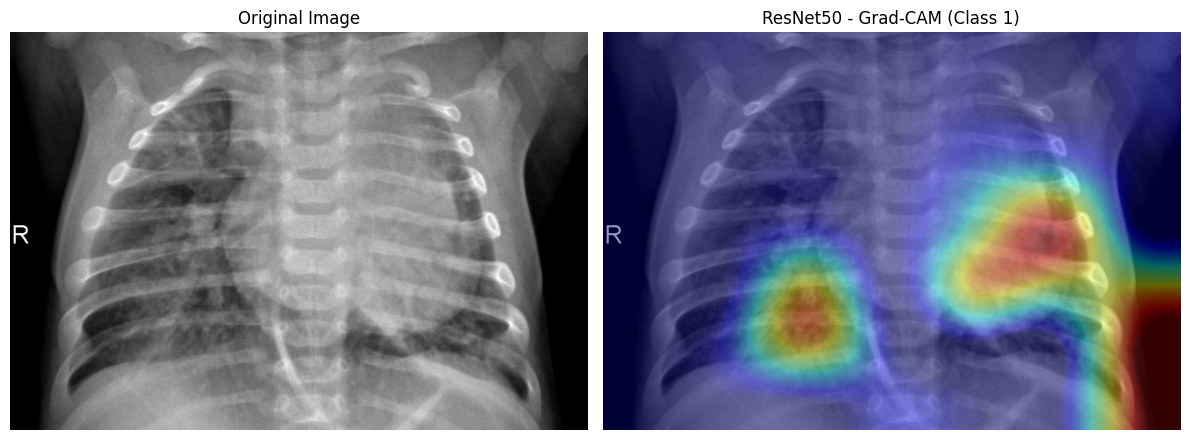

In [61]:

# Load an image from your test set
img_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"  # change this
original_img = Image.open(img_path)

# Convert to RGB to ensure 3 channels for overlay_mask
img = original_img.convert('RGB')

# Transform (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean2, std=std2),
])

input_tensor = transform(img).unsqueeze(0).to(device)  # add batch dim

# Use the last conv layer (usually "layer4")
cam_extractor = GradCAM(model, target_layer="layer4")

# Forward pass
output = model(input_tensor)
pred_class = output.argmax().item()

# Get CAM
activation_map = cam_extractor(pred_class, output)

# Process the activation map for better visualization
cam = activation_map[0].squeeze(0).cpu().detach().numpy()

# Normalize to 0-1 range
cam = np.maximum(cam, 0)  # ReLU to remove negative values
cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # Normalize

# Resize to match original image size
original_size = img.size  # (width, height)
cam_resized = cv2.resize(cam, original_size, interpolation=cv2.INTER_CUBIC)

# Apply Gaussian blur for smoother visualization
cam_smooth = cv2.GaussianBlur(cam_resized, (21, 21), 0)

# Create heatmap using jet colormap for rainbow effect
heatmap = cm.jet(cam_smooth)[:, :, :3]  # Remove alpha channel
heatmap = (heatmap * 255).astype(np.uint8)

# Convert original image to numpy array
img_array = np.array(img).astype(np.float32)

# Blend the original image with heatmap
alpha = 0.4  # Weight for heatmap
beta = 0.6   # Weight for original image
result_array = (alpha * heatmap + beta * img_array).astype(np.uint8)
result = Image.fromarray(result_array)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(result)
plt.title(f"ResNet50 - Grad-CAM (Class {pred_class})")
plt.axis("off")
plt.tight_layout()
plt.show()